# Intro to Tree Methods

Review Chapter 8 of Introduction to Statistical Learning (Gareth James et al.)

http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf

* Decision Tree 
    * Root Nodes: node that performs first split
    * Nodes: split for the value of a certain attribute (feature)
    * Edges: outcome  of a split to next node
* Entropy and Information Gain are the mathematical methos of choosing the best split (see Chaper 8)
    * Entropy: \begin{equation*} H(S) = \sum_{i} p_{i}(S) log_{2} p_{i}(S) \end{equation*}
    * Information Gain: \begin{equation*} IG(S,A) = H(S) - \sum_{v\in Values(A)} \frac{|S_{v}|}{S}H(S_{v}) \end{equation*}
* Intuition is to try to choose the features that best split the data, aka maximize your information gain off of the split


### Random Forests
* primary weakness of decision trees is that they don't tend to have the best predictive accuracy
* this is parially due to the high variance, meaning different splits in the training data can lead to very different trees
* bagging is a general purpose procedure for reducing variance
* build off the idea of bagging by using random forests
* random forests is a slight variation of bagged trees
* in random forests, we create an ensemble of decision trees using bootstraped samples of the training set
* bootstraped samples of the training set = sampling of the training set with replacement
* however, each time we're building a tree, each time a split is considered, a random sample of **m** features is chosen as a split candidate from the full set of **p** features, where the split is only allowed to use the random sample of features
* to impove performance, use many trees with arandom sample of features chosen as the split
* A new random sample of features is chosen for **every single tree at every single split**
* For **classification**, **m** (random sample of features) is typically chosen to be the sqaure root of **p** (full set of features)

Whats the point of using Random Forests?
* Suppose there is **one very strong feature** in the data set
* When using "bagged" trees, most of the trees will use that feature as the top split, resulting in an ensemble of very similar trees that are **highly correlated**
    * this is something we want to avoid
* Averaging highly correlated quantities oes not significantly reduce variance
* By randomly leaving out candidate features form each split, **Random Forests "decorrelates" the trees* (making trees independent of each other), such that the averaging process can reduce the variance of the resulting model, so we won't be affected by features that strongly predict the class data


___
# Decision Trees and Random Forests in Python

This is the code for the lecture video which goes over tree methods in Python. Reference the video lecture for the full explanation of the code!

I also wrote a [blog post](https://medium.com/@josemarcialportilla/enchanted-random-forest-b08d418cb411#.hh7n1co54) explaining the general logic of decision trees and random forests which you can check out. 

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Get the Data

In [2]:
# kyphosis data = number of patients that had kyphosis spinal condition, then had an corrective spinal surgery operation
# data represents where the kyphosis condition was absent/present after the op
df = pd.read_csv("kyphosis.csv")

In [3]:
df.head()
# Age in months
# Number = number of vertebrae involved in te op
# Start = top most vertebrea operated on

,Kyphosis,Age,Number,Start
0,absent,71,3,5
1,absent,158,3,14
2,present,128,4,5
3,absent,2,5,1
4,absent,1,4,15


In [4]:
df.info()
# small data set

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 4 columns):
Kyphosis    81 non-null object
Age         81 non-null int64
Number      81 non-null int64
Start       81 non-null int64
dtypes: int64(3), object(1)
memory usage: 2.7+ KB


In [5]:
df.describe()

,Age,Number,Start
count,81.000000,81.000000,81.000000
mean,83.654321,4.049383,11.493827
std,58.104251,1.619423,4.883962
min,1.000000,2.000000,1.000000
25%,26.000000,3.000000,9.000000
50%,87.000000,4.000000,13.000000
75%,130.000000,5.000000,16.000000
max,206.000000,10.000000,18.000000


## EDA

We'll just check out a simple pairplot for this small dataset.

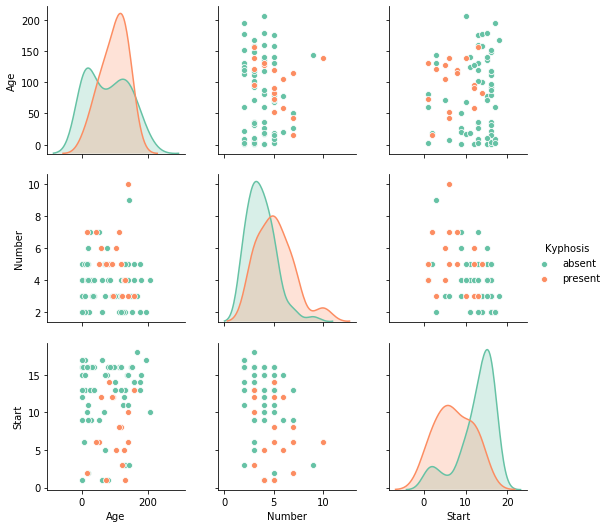

In [7]:
sns.pairplot(df, hue='Kyphosis', palette='Set2', diag_kind='kde')

## Train Test Split

Let's split up the data into a training set and a test set!

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X = df.drop('Kyphosis', axis=1)

In [10]:
y = df['Kyphosis']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

## Decision Trees

We'll start just by training a single decision tree.

In [12]:
from sklearn.tree import DecisionTreeClassifier 

In [13]:
dtree = DecisionTreeClassifier()
# fine tune params here
# leave default params to start

In [14]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

## Prediction and Evaluation 

Let's evaluate our decision tree.

In [15]:
predictions = dtree.predict(X_test)

In [16]:
predictions[:10]

array(['absent', 'absent', 'present', 'absent', 'absent', 'absent',
       'absent', 'absent', 'absent', 'absent'], dtype=object)

In [17]:
from sklearn.metrics import classification_report, confusion_matrix 

In [50]:
print(classification_report(y_test,predictions))
# 72% accuracy

              precision    recall  f1-score   support

      absent       0.77      0.89      0.83        19
     present       0.33      0.17      0.22         6

    accuracy                           0.72        25
   macro avg       0.55      0.53      0.53        25
weighted avg       0.67      0.72      0.68        25



In [18]:
print(confusion_matrix(y_test,predictions))
# TN, FN
# FP, TP
# 10 misclassified

[[17  2]
 [ 4  2]]


## Tree Visualization

Scikit learn actually has some built-in visualization capabilities for decision trees, you won't use this often,
* because you'll use Random forests that are much harder to vizualize
* it requires you to install the pydot library
    * conda install -c anaconda pydot

but here is an example of what it looks like and the code to execute this:

In [29]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot 

features = list(df.columns[1:])
features

['Age', 'Number', 'Start']

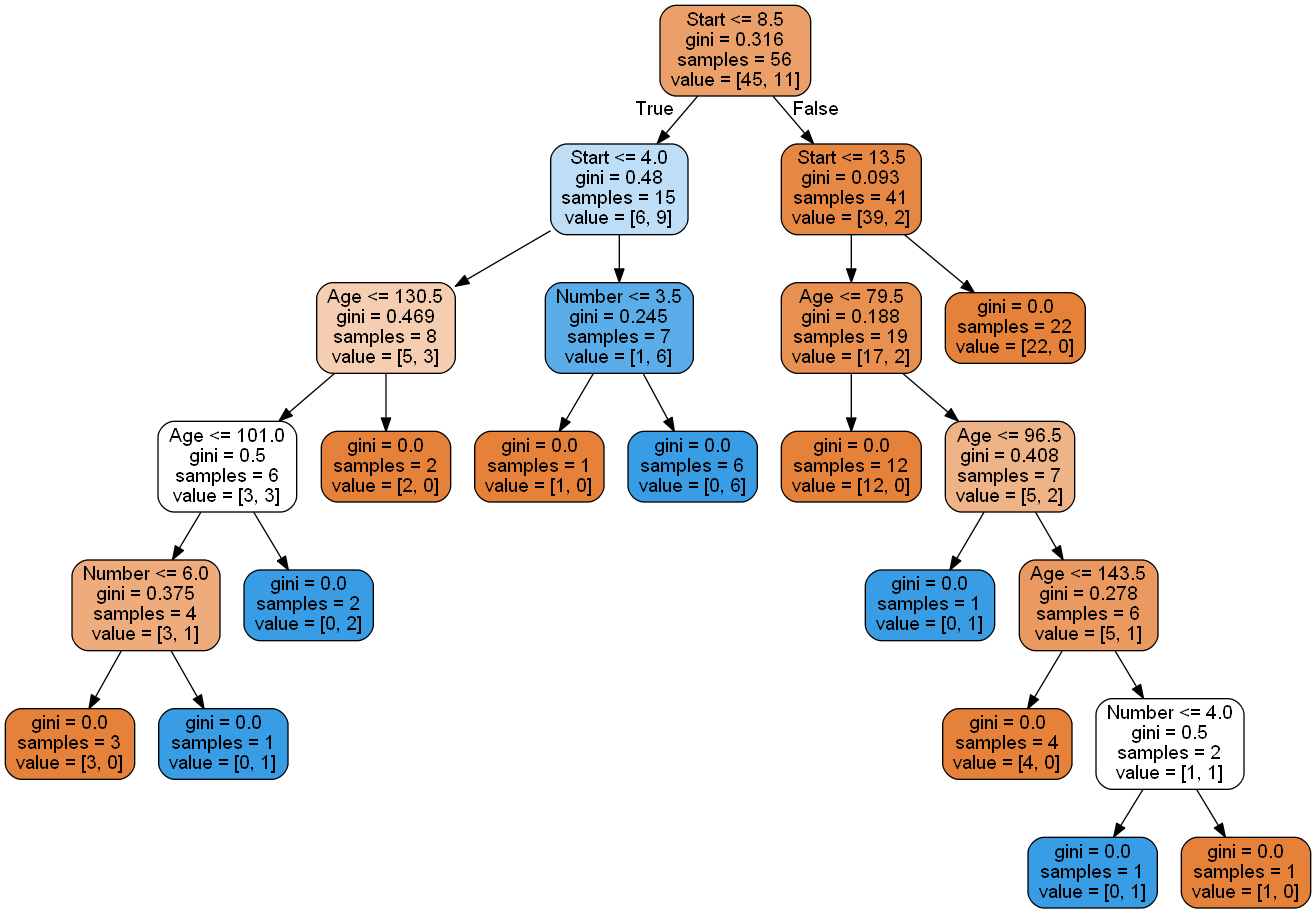

In [30]:
dot_data = StringIO()  
export_graphviz(dtree, out_file=dot_data,feature_names=features,filled=True,rounded=True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png()) 

## Random Forests

Now let's compare the decision tree model to a random forest.

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
rfc = RandomForestClassifier(n_estimators=200)
# 200 estimators should be fine for small data set, probably overkill

In [21]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [22]:
predictions_rfc = rfc.predict(X_test)

In [23]:
predictions_rfc[:10]

array(['absent', 'absent', 'absent', 'absent', 'absent', 'absent',
       'absent', 'absent', 'absent', 'absent'], dtype=object)

In [24]:
print(classification_report(y_test,predictions_rfc))
# 80% accuracy
# Random forsts outshine decision tree in most cases
# random forest ensemble methods significanlty increased accuracy
# performance depends on whether you want higher precision or recall
# and whether you favor absent or present

              precision    recall  f1-score   support

      absent       0.79      1.00      0.88        19
     present       1.00      0.17      0.29         6

    accuracy                           0.80        25
   macro avg       0.90      0.58      0.58        25
weighted avg       0.84      0.80      0.74        25



In [25]:
print(confusion_matrix(y_test,predictions_rfc))
# TN, FN
# FP, TP
# 5 misclassified

[[19  0]
 [ 5  1]]


In [26]:
df['Kyphosis'].value_counts()
# there are alot more cases of absent than present
# this skew can affect the model

absent     64
present    17
Name: Kyphosis, dtype: int64

In [27]:
y_test.value_counts()

absent     19
present     6
Name: Kyphosis, dtype: int64